In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from pathlib import Path
import os
from torch.utils.data import Dataset, DataLoader
import pickle
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


# Import your encoders
from latent_audio_encoder import LatentAudioEncoder
from speech_text_encoder import SpeechTextEncoder
from combined_audio_encoder import CombinedAudioEncoder

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using devic e: {device}")

✅ Using devic e: cuda


In [3]:
def load_transcript_cache(pkl_path):
    """Load the precomputed transcript cache"""
    print(f"📁 Loading transcript cache from: {pkl_path}")
    with open(pkl_path, 'rb') as f:
        transcript_data = pickle.load(f)
    print(f"✅ Loaded {len(transcript_data['transcripts'])} transcripts")
    return transcript_data

def load_audio_embeddings(pkl_path):
    """Load pre-computed audio embeddings"""
    print(f"📁 Loading audio embeddings from: {pkl_path}")
    with open(pkl_path, 'rb') as f:
        data = pickle.load(f)
    
    embeddings = data['embeddings']
    metadata = data.get('metadata', {})
    config = data.get('config', {})
    
    print(f"✅ Loaded {len(embeddings)} audio embeddings")
    if config:
        print(f"   Segment duration: {config.get('segment_duration', 'N/A')}s")
        print(f"   Sample rate: {config.get('sample_rate', 'N/A')} Hz")
    
    return embeddings, metadata

def get_transcript(transcript_data, audio_path, timestamp):
    """Retrieve transcript for a given audio file and timestamp"""
    key = f"{Path(audio_path).stem}_{timestamp:.2f}"
    return transcript_data['transcripts'].get(key, "")


In [4]:
# ============================================================
# 2️⃣ Dataset Class
# ============================================================

import soundfile as sf

class FastAudioDataset(Dataset):
    def __init__(self, df, transcript_data, audio_embeddings):
        self.df = df
        self.transcript_data = transcript_data
        self.audio_embeddings = audio_embeddings

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Get pre-computed audio embedding
        key = f"{Path(row['audio_path']).stem}_{row['time_seconds']:.2f}"
        audio_emb = self.audio_embeddings[key]
        
        # Get transcript
        transcript = get_transcript(self.transcript_data, row['audio_path'], row['time_seconds'])
        
        label = row['label']
        
        return audio_emb, transcript, label


In [5]:
def train_model(
    csv_path,
    transcript_pkl_path,
    audio_embeddings_path,
    num_epochs=5,
    batch_size=64,
    learning_rate=1e-4,
    device='cuda'
):
    """Fast training function using pre-computed embeddings"""
    
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    print(f"✅ Using device: {device}\n")
    
    # Load pre-computed data
    transcript_data = load_transcript_cache(transcript_pkl_path)
    audio_embeddings, audio_metadata = load_audio_embeddings(audio_embeddings_path)
    
    # Load encoders (only need speech encoder for text)
    print("\n🔧 Loading encoders...")
    speech_encoder = SpeechTextEncoder().to(device)
    combined_encoder = CombinedAudioEncoder().to(device)
    
    # Freeze speech encoder
    for p in speech_encoder.parameters():
        p.requires_grad = False
    speech_encoder.eval()
    
    print(f"  ✅ Speech encoder: {next(speech_encoder.text_model.parameters()).device}")
    print(f"  ✅ Combined encoder: {next(combined_encoder.parameters()).device}")
    
    # Load dataset
    print(f"\n📊 Loading dataset...")
    df = pd.read_csv(csv_path)
    df = df.sample(frac=1, random_state=42)
    print(f"  Total samples: {len(df)}")
    
    # Create label mapping
    label_to_id = {lbl: i for i, lbl in enumerate(sorted(df['label'].unique()))}
    id_to_label = {i: lbl for lbl, i in label_to_id.items()}
    num_classes = len(label_to_id)
    print(f"  Number of classes: {num_classes}")
    
    # Create fast dataset
    dataset = FastAudioDataset(df, transcript_data, audio_embeddings)
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=4,
        pin_memory=True,
        persistent_workers=True
    )
    
    # Create classifier
    # Get embedding dimension from first sample
    first_emb = audio_embeddings[list(audio_embeddings.keys())[0]]
    emb_dim = combined_encoder.audio_proj.out_features
    
    classifier = nn.Sequential(
        nn.Linear(emb_dim, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    ).to(device)
    
    print(f"\n🎯 Classifier created")
    print(f"  Input dim: {emb_dim}")
    print(f"  Output classes: {num_classes}")
    
    # Setup training
    optimizer = torch.optim.Adam(
        list(combined_encoder.parameters()) + list(classifier.parameters()),
        lr=learning_rate
    )
    scaler = torch.cuda.amp.GradScaler()
    criterion = nn.CrossEntropyLoss()
    
    # Training loop
    losses = []
    accuracies = []
    
    print(f"\n🚀 Starting training for {num_epochs} epochs...\n")
    
    for epoch in range(num_epochs):
        combined_encoder.train()
        classifier.train()
        
        epoch_losses = []
        correct = 0
        total = 0
        
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for audio_embs, transcripts, labels in pbar:
            try:
                # Convert labels to IDs
                label_ids = torch.tensor([label_to_id[l] for l in labels], device=device)
                
                # Move audio embeddings to device
                audio_embs = audio_embs.to(device)
                if audio_embs.dim() == 3:
                    audio_embs = audio_embs.squeeze(1)
                
                # Use mixed precision
                with torch.cuda.amp.autocast():
                    # Get text embeddings in batch
                    with torch.no_grad():
                        non_empty_transcripts = [t if t.strip() else " " for t in transcripts]
                        
                        text_inputs = speech_encoder.text_tokenizer(
                            non_empty_transcripts,
                            return_tensors="pt",
                            padding=True,
                            truncation=True,
                            max_length=512
                        )
                        text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
                        
                        outputs = speech_encoder.text_model(**text_inputs)
                        text_embs = outputs.last_hidden_state.mean(dim=1)
                    
                    # Fuse embeddings
                    fused = combined_encoder(audio_embs, text_embs)
                    
                    # Classify
                    logits = classifier(fused)
                    loss = criterion(logits, label_ids)
                
                # Backward with mixed precision
                optimizer.zero_grad()
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                
                # Track metrics
                epoch_losses.append(loss.item())
                _, predicted = torch.max(logits, 1)
                total += label_ids.size(0)
                correct += (predicted == label_ids).sum().item()
                
                pbar.set_postfix({'loss': f'{loss.item():.4f}'})
                
            except Exception as e:
                print(f"\n❌ Error in batch: {e}")
                import traceback
                traceback.print_exc()
                continue
        
        # Epoch summary
        avg_loss = sum(epoch_losses) / len(epoch_losses) if epoch_losses else 0
        accuracy = 100 * correct / total
        
        losses.append(avg_loss)
        accuracies.append(accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}%")
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(losses, linewidth=2, marker='o')
    ax1.set_title("Training Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(accuracies, linewidth=2, marker='o', color='green')
    ax2.set_title("Training Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy (%)")
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_results.png', dpi=150)
    plt.show()
    
    print(f"\n✅ Training complete!")
    print(f"Final Loss: {losses[-1]:.4f}")
    print(f"Final Accuracy: {accuracies[-1]:.2f}%")
    
    return combined_encoder, classifier, label_to_id, id_to_label


In [6]:
def evaluate_model(
    csv_path,
    transcript_pkl_path,
    combined_encoder,
    classifier,
    label_to_id,
    id_to_label,
    device='cuda'
):
    """Evaluate model on test set"""
    
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    
    # Load data
    transcript_data = load_transcript_cache(transcript_pkl_path)
    df = pd.read_csv(csv_path)
    
    # Load encoders
    latent_encoder = LatentAudioEncoder().to(device)
    speech_encoder = SpeechTextEncoder().to(device)
    latent_encoder.eval()
    speech_encoder.eval()
    combined_encoder.eval()
    classifier.eval()
    
    # Create dataset
    dataset = AudioDataset(df, transcript_data)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    all_predictions = []
    all_labels = []
    
    print(f"\n🔮 Evaluating on {len(df)} samples...")
    
    with torch.no_grad():
        for waveforms, transcripts, labels in tqdm(dataloader):
            waveform = waveforms[0].squeeze().to(device)
            transcript = transcripts[0]
            label = labels[0]
            
            # Get embeddings
            audio_emb = latent_encoder(waveform, sampling_rate=16000)
            text_emb = speech_encoder.get_text_embedding(transcript)
            
            # Fuse and classify
            audio_emb = audio_emb.unsqueeze(0)
            text_emb = text_emb.unsqueeze(0)
            fused = combined_encoder(audio_emb, text_emb)
            logits = classifier(fused)
            
            _, predicted = torch.max(logits, 1)
            all_predictions.append(id_to_label[predicted.item()])
            all_labels.append(label)
    
    # Calculate overall accuracy
    correct = sum(p == l for p, l in zip(all_predictions, all_labels))
    accuracy = 100 * correct / len(all_labels)
    
    print(f"\n📊 Overall Accuracy: {accuracy:.2f}%")
    
    # Per-class accuracy
    print(f"\n📈 Per-Class Accuracy:")
    for label in sorted(set(all_labels)):
        indices = [i for i, l in enumerate(all_labels) if l == label]
        class_correct = sum(all_predictions[i] == all_labels[i] for i in indices)
        class_acc = 100 * class_correct / len(indices)
        print(f"  {label}: {class_acc:.1f}% ({class_correct}/{len(indices)})")
    
    return accuracy, all_predictions, all_labels


⚡ FAST TRAINING WITH PRE-COMPUTED EMBEDDINGS
Batch size: 128
Epochs: 10
Learning rate: 0.0003
✅ Using device: cuda

📁 Loading transcript cache from: ../transcript_cache/transcripts_window_10s_centered.pkl
✅ Loaded 5832 transcripts
📁 Loading audio embeddings from: ../audio_embeddings_cache/audio_embeddings.pkl
✅ Loaded 5832 audio embeddings
   Segment duration: 20.0s
   Sample rate: 16000 Hz

🔧 Loading encoders...
  ✅ Speech encoder: cuda:0
  ✅ Combined encoder: cuda:0

📊 Loading dataset...
  Total samples: 66460
  Number of classes: 17

🎯 Classifier created
  Input dim: 512
  Output classes: 17

🚀 Starting training for 10 epochs...



/tmp/ipykernel_2021534/4093261555.py:76: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...

Epoch 1/10:   0%|          | 0/520 [00:00<?, ?it/s]

/tmp/ipykernel_2021534/4093261555.py:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/10 | Loss: 2.2366 | Accuracy: 29.04%


Epoch 2/10:   0%|          | 0/520 [00:00<?, ?it/s]

Epoch 2/10 | Loss: 2.2144 | Accuracy: 29.54%


Epoch 3/10:   0%|          | 0/520 [00:00<?, ?it/s]

Epoch 3/10 | Loss: 2.2106 | Accuracy: 29.55%


Epoch 4/10:   0%|          | 0/520 [00:00<?, ?it/s]

Epoch 4/10 | Loss: 2.2073 | Accuracy: 29.54%


Epoch 5/10:   0%|          | 0/520 [00:00<?, ?it/s]

Epoch 5/10 | Loss: 2.2044 | Accuracy: 29.56%


Epoch 6/10:   0%|          | 0/520 [00:00<?, ?it/s]

Epoch 6/10 | Loss: 2.1997 | Accuracy: 29.59%


Epoch 7/10:   0%|          | 0/520 [00:00<?, ?it/s]

Epoch 7/10 | Loss: 2.1923 | Accuracy: 29.61%


Epoch 8/10:   0%|          | 0/520 [00:00<?, ?it/s]

Epoch 8/10 | Loss: 2.1863 | Accuracy: 29.58%


Epoch 9/10:   0%|          | 0/520 [00:00<?, ?it/s]

Epoch 9/10 | Loss: 2.1767 | Accuracy: 29.66%


Epoch 10/10:   0%|          | 0/520 [00:00<?, ?it/s]

Epoch 10/10 | Loss: 2.1667 | Accuracy: 29.60%


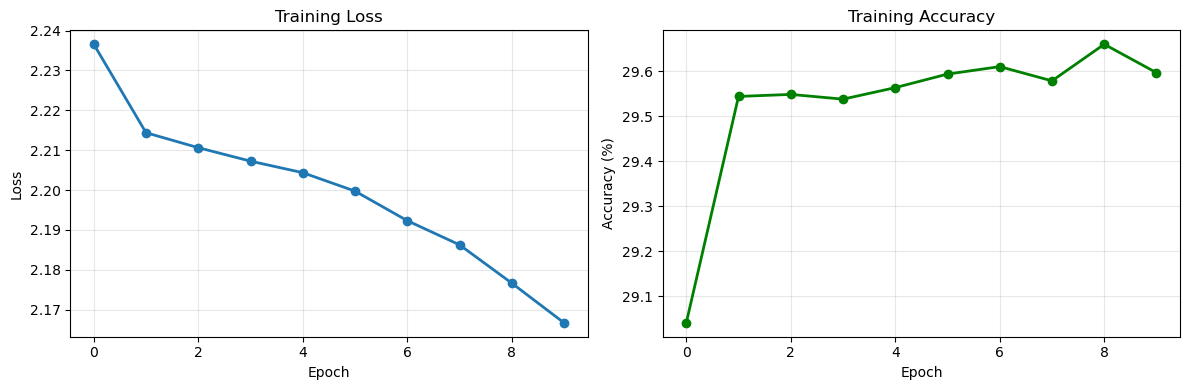


✅ Training complete!
Final Loss: 2.1667
Final Accuracy: 29.60%

💾 Model saved to 'trained_model.pth'


In [10]:
CSV_PATH = "../SoccerNet_audio_labels.csv"
TRANSCRIPT_PKL = "../transcript_cache/transcripts_window_10s_centered.pkl"
AUDIO_EMBEDDINGS_PKL = "../audio_embeddings_cache/audio_embeddings.pkl"
DEVICE = "cuda"
NUM_EPOCHS = 10
BATCH_SIZE = 128  # Can be much larger now!
LEARNING_RATE = 3e-4

print("="*60)
print("⚡ FAST TRAINING WITH PRE-COMPUTED EMBEDDINGS")
print("="*60)
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print("="*60)

# Train
combined_encoder, classifier, label_to_id, id_to_label = train_model(
    csv_path=CSV_PATH,
    transcript_pkl_path=TRANSCRIPT_PKL,
    audio_embeddings_path=AUDIO_EMBEDDINGS_PKL,
    num_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    device=DEVICE
)

# Save model
torch.save({
    'combined_encoder': combined_encoder.state_dict(),
    'classifier': classifier.state_dict(),
    'label_to_id': label_to_id,
    'id_to_label': id_to_label
}, 'trained_model.pth')
print(f"\n💾 Model saved to 'trained_model.pth'")
    